In [384]:
import time

import sklearn.metrics
from numpy import arange, c_
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, RidgeClassifier
from sklearn import datasets

from scipy import optimize

import numpy as np

from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay, RocCurveDisplay, roc_curve

import matplotlib.pyplot as plt

import pandas as pd


def calculate_ridge(X_param, y_param, k):
    return np.linalg.pinv((X_param.T @ X_param) + (k * np.identity(len(X_param.T)))) @ (X_param.T @ y_param) * 2


def my_normalize(matrix):
    return (matrix - np.min(matrix))/(np.max(matrix) - np.min(matrix))


def f_wielomian(w, x):
    x = np.c_[np.ones((x.shape[0], 1)), x]
    y = x @ w
    return y


def normal_equation_ridge_regression(X_param, y_param, alpha):
    intercept_ones = np.ones((len(X_param), 1))        # results in array( [ [1],..,[1] ] )
    X_b = np.c_[intercept_ones, X_param]               # we now add the additional ones as a new column to our X
    I = np.identity(X_b.shape[1])               # identity matrix with dimensions (n+1)
    I[0][0] = 0                                 # adjusting the first value in I to be 0, to account for the intercept term
    theta_optimal = np.linalg.pinv(X_b.T.dot(X_b) + alpha * I).dot(X_b.T).dot(y_param) # the normal equation
    return theta_optimal


noise = 16
samples = 2425
seed = 244825
classes = 2
train_split = 0.8
test_split = 0.2
repeats = 100

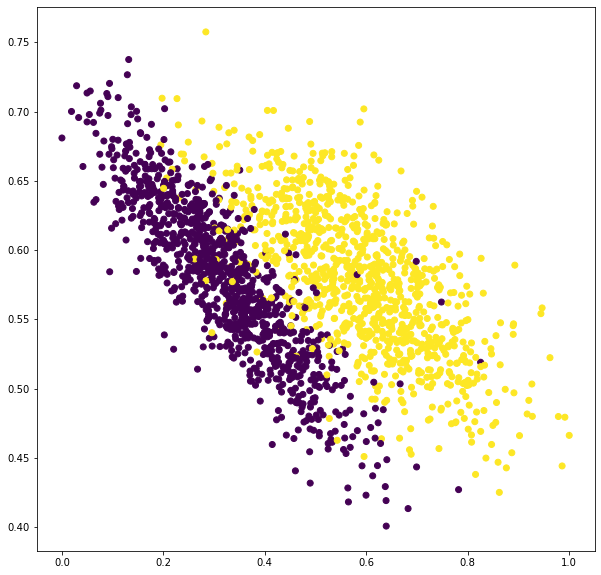

In [385]:
X, y = datasets.make_classification(n_features=2, random_state=seed, n_redundant=0, n_samples=samples, n_classes=2, n_clusters_per_class=1)


X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_split, test_size=test_split, random_state=seed)

xx, yy = np.meshgrid(np.arange(-0.25, 1.25, 0.01),
                       np.arange(-0.25, 1.25, 0.01))
#
X_train = my_normalize(X_train)
X_test = my_normalize(X_test)

y_test[y_test == 0] = -1
y_train[y_train == 0] = -1



plt.figure(figsize=(10,10))
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train)

In [386]:
def calculate_value(theta, pX):
    return pX @ theta


def label_data(data, mean):
    ans = list()
    for x in data:
        if x >= mean:
            ans.append(1.0)
        else:
            ans.append(-1.0)
    return np.asarray(ans)

start_analytical = time.perf_counter()
for i in range(repeats):
    my_ridge = normal_equation_ridge_regression(X_train, y_train, 1)
analytical_time = time.perf_counter() - start_analytical

my_ridge = my_ridge.reshape((3,1))


y_predicted = f_wielomian(my_ridge, np.c_[xx.ravel(), yy.ravel()])

mean = np.mean(y_predicted)

y_predicted = label_data(y_predicted, 0)


y_predicted = y_predicted.reshape(xx.shape)

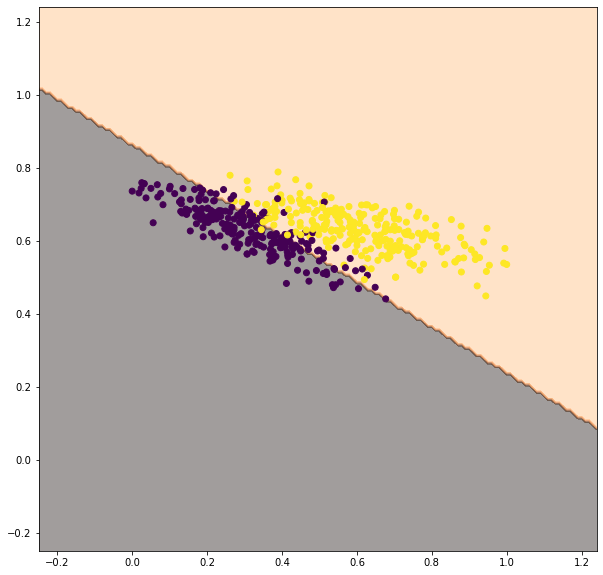

In [387]:
plt.figure(figsize=(10,10))
plt.contourf(xx, yy, y_predicted, alpha=0.4, cmap='copper')
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test)

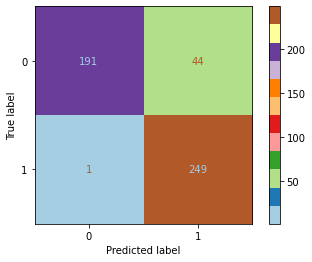

In [388]:
values = f_wielomian(my_ridge, X_test)
values = label_data(values, 0)
cm_analytical = confusion_matrix(y_test, values)
tn_analytical = cm_analytical[0][0]
fn_analytical = cm_analytical[0][1]
tp_analytical = cm_analytical[1][1]
fp_analytical = cm_analytical[1][0]
ConfusionMatrixDisplay(cm_analytical).plot(cmap='Paired')

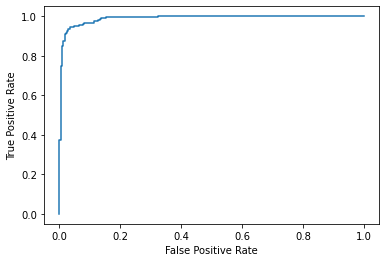

In [389]:
fpr, tpr, roc_auc = roc_curve(y_test, f_wielomian(my_ridge, X_test))

rok_analitic = RocCurveDisplay(fpr=fpr, tpr=tpr)
rok_analitic.plot()

In [390]:
model_ridge = RidgeClassifier(copy_X=True)

start_ridge = time.perf_counter()
for i in range(repeats):
    model_ridge.fit(X_train, y_train)
ridge_time = time.perf_counter() - start_ridge

predict = model_ridge.predict(c_[xx.ravel(), yy.ravel()])

predict = predict.reshape(xx.shape)

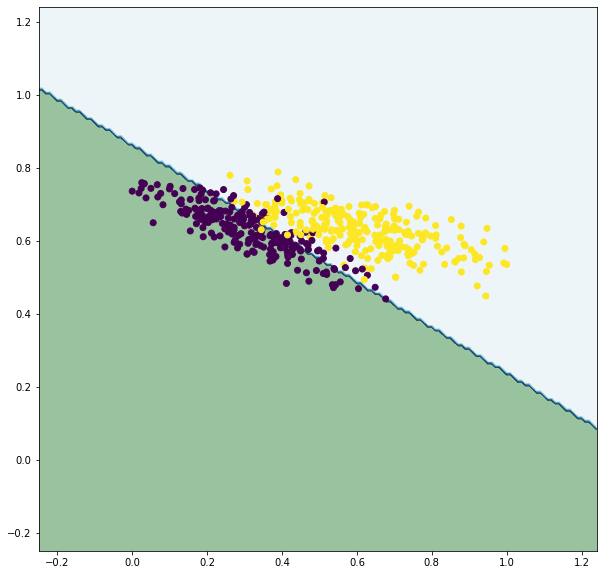

In [391]:
plt.figure(figsize=(10,10))
plt.contourf(xx, yy, predict, alpha=0.4, cmap='ocean')
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test)

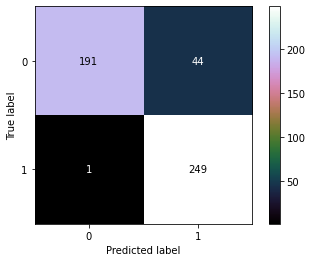

In [392]:
cm_model = confusion_matrix(y_test, model_ridge.predict(X_test))
tn_model = cm_model[0][0]
fn_model = cm_model[0][1]
tp_model = cm_model[1][1]
fp_model = cm_model[1][0]
ConfusionMatrixDisplay(cm_model).plot(cmap='cubehelix')

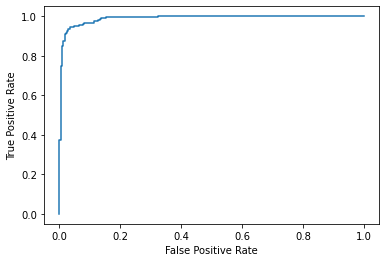

In [393]:
fpr, tpr, roc_auc = roc_curve(y_test, model_ridge.decision_function(X_test))

rok_model = RocCurveDisplay(fpr=fpr, tpr=tpr)
rok_model.plot()

### Podsumowanie

Czas wykonania analityczna: 0.013948299980256706
Czas wykonania ridge: 0.11852339998586103
Czulosc analityczna: 0.8498293515358362
Czulosc ridge: 0.8498293515358362
Swoistosc analityczna: 0.9947916666666666
Swoistosc ridge: 0.9947916666666666
Accuracy analityczna 0.9072164948453608
Accuracy ridge 0.9072164948453608

Macierz pomylek analityczny
 [[191  44]
 [  1 249]]

Macierz pomylek model
 [[191  44]
 [  1 249]]


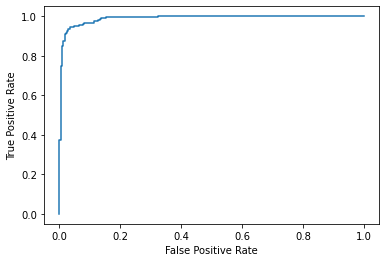

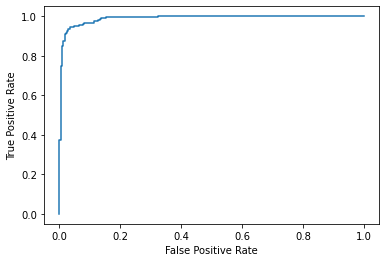

In [394]:
print("Czas wykonania analityczna:", analytical_time)
print("Czas wykonania ridge:", ridge_time)

print("Czulosc analityczna:", tp_analytical/(tp_analytical + fn_analytical))
print("Czulosc ridge:", tp_model/(tp_model + fn_model))

print("Swoistosc analityczna:", tn_analytical/(tn_analytical + fp_analytical))
print("Swoistosc ridge:", tn_model/(tn_model + fp_model))

print("Accuracy analityczna", (tp_analytical + tn_analytical) / (tp_analytical + tn_analytical + fp_analytical + fn_analytical))
print("Accuracy ridge", (tp_model + tn_model) / (tp_model + tn_model + fp_model + fn_model))

print("\nMacierz pomylek analityczny\n",cm_analytical)
print("\nMacierz pomylek model\n",cm_model)

rok_analitic.plot()
rok_model.plot()

# Eksploracja danych i uzasadniona odpowied¹ na pytanie

In [395]:
import scipy.stats.mstats as mst

column_names = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'class']
cleveland = pd.read_csv('processed.cleveland.data', names=column_names, header=None)
cleveland = cleveland.apply(pd.to_numeric, errors='coerce')
cleveland = cleveland.dropna()
cleveland.loc[cleveland['class'] > 0, 'class'] = 1
cleveland.loc[cleveland['class'] == 0, 'class'] = -1
cleveland

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,class
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,-1
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,1
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,-1
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,57.0,0.0,4.0,140.0,241.0,0.0,0.0,123.0,1.0,0.2,2.0,0.0,7.0,1
298,45.0,1.0,1.0,110.0,264.0,0.0,0.0,132.0,0.0,1.2,2.0,0.0,7.0,1
299,68.0,1.0,4.0,144.0,193.0,1.0,0.0,141.0,0.0,3.4,2.0,2.0,7.0,1
300,57.0,1.0,4.0,130.0,131.0,0.0,0.0,115.0,1.0,1.2,2.0,1.0,7.0,1


In [396]:
miary = {'Age': cleveland['age'].mean(),
         'Sex': cleveland['sex'].median(),
         'CP': cleveland['cp'].mode(),
         'Trestbps': cleveland['trestbps'].mean(),
         'Chol': cleveland['chol'].mean(),
         'FBS': cleveland['fbs'].mode(),
         'Restecg': cleveland['restecg'].mode(),
         'Thalach': cleveland['thalach'].mean(),
         'Exang': cleveland['exang'].mode(),
         'Oldpeak': cleveland['oldpeak'].mean(),
         'Slope': cleveland['slope'].mode(),
         'Thal': cleveland['thal'].mode(),
         'Ca': cleveland['ca'].mode(),
         'Class': cleveland['class'].mode()
            }
miary

{'Age': 54.54208754208754,
 'Sex': 1.0,
 'CP': 0    4.0
 Name: cp, dtype: float64,
 'Trestbps': 131.69360269360268,
 'Chol': 247.35016835016836,
 'FBS': 0    0.0
 Name: fbs, dtype: float64,
 'Restecg': 0    0.0
 Name: restecg, dtype: float64,
 'Thalach': 149.5993265993266,
 'Exang': 0    0.0
 Name: exang, dtype: float64,
 'Oldpeak': 1.0555555555555558,
 'Slope': 0    1.0
 Name: slope, dtype: float64,
 'Thal': 0    3.0
 Name: thal, dtype: float64,
 'Ca': 0    0.0
 Name: ca, dtype: float64,
 'Class': 0   -1
 Name: class, dtype: int64}

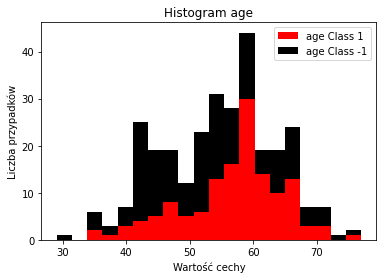

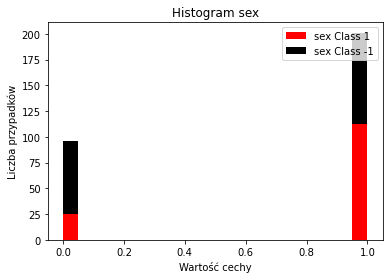

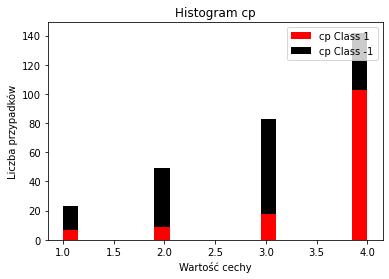

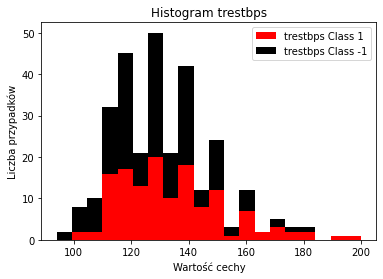

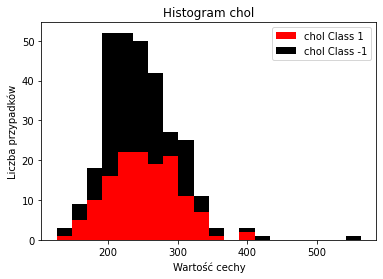

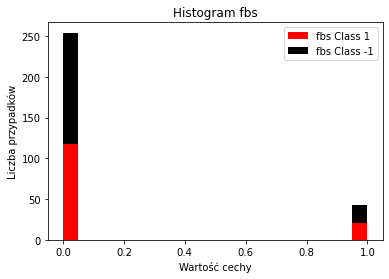

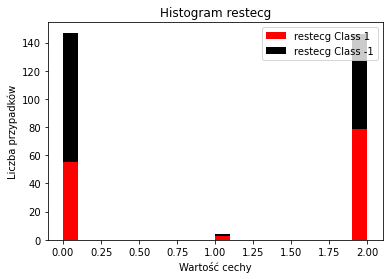

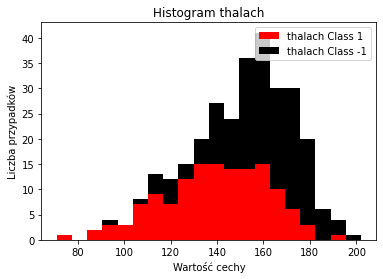

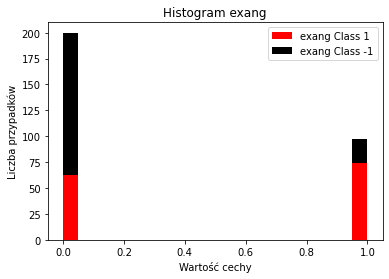

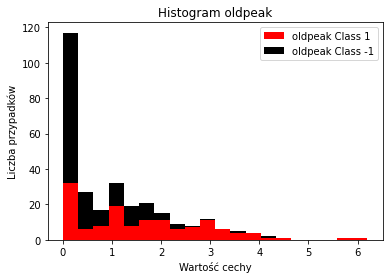

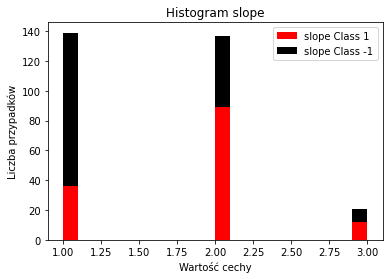

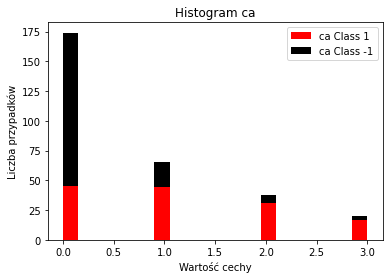

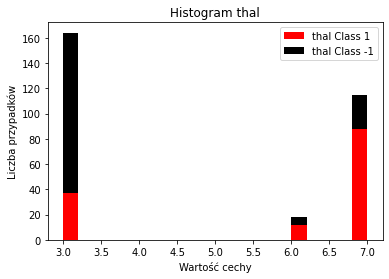

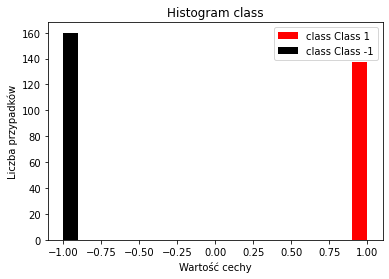

In [397]:
def show_histograms(histkolumna):
    x = cleveland[cleveland['class'] == 1.0][histkolumna]
    y = cleveland[cleveland['class'] == -1.0][histkolumna]
    plt.hist([x,y], 20, label=[histkolumna + ' Class 1', histkolumna + ' Class -1'], stacked=True, color=['red', 'k'])
    plt.title("Histogram " + str(histkolumna))
    plt.legend(loc='upper right')
    plt.xlabel('Wartość cechy')
    plt.ylabel('Liczba przypadków')
    plt.show()

for x in cleveland.columns:
    show_histograms(x)

In [398]:
cleveland.corr().style.background_gradient(cmap='viridis')

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,class
age,1.000000,-0.092399,0.110471,0.290476,0.202644,0.132062,0.149917,-0.394563,0.096489,0.197123,0.159405,0.362210,0.126586,0.227075
sex,-0.092399,1.000000,0.008908,-0.066340,-0.198089,0.038850,0.033897,-0.060496,0.143581,0.106567,0.033345,0.091925,0.383652,0.278467
cp,0.110471,0.008908,1.000000,-0.036980,0.072088,-0.057663,0.063905,-0.339308,0.377525,0.203244,0.151079,0.235644,0.268500,0.408945
trestbps,0.290476,-0.066340,-0.036980,1.000000,0.131536,0.180860,0.149242,-0.049108,0.066691,0.191243,0.121172,0.097954,0.138183,0.153490
chol,0.202644,-0.198089,0.072088,0.131536,1.000000,0.012708,0.165046,-0.000075,0.059339,0.038596,-0.009215,0.115945,0.010859,0.080285
fbs,0.132062,0.038850,-0.057663,0.180860,0.012708,1.000000,0.068831,-0.007842,-0.000893,0.008311,0.047819,0.152086,0.062209,0.003167
restecg,0.149917,0.033897,0.063905,0.149242,0.165046,0.068831,1.000000,-0.072290,0.081874,0.113726,0.135141,0.129021,0.018795,0.166343
thalach,-0.394563,-0.060496,-0.339308,-0.049108,-0.000075,-0.007842,-0.072290,1.000000,-0.384368,-0.347640,-0.389307,-0.268727,-0.274831,-0.423817
exang,0.096489,0.143581,0.377525,0.066691,0.059339,-0.000893,0.081874,-0.384368,1.000000,0.289310,0.250572,0.148232,0.326927,0.421355
oldpeak,0.197123,0.106567,0.203244,0.191243,0.038596,0.008311,0.113726,-0.347640,0.289310,1.000000,0.579037,0.294452,0.344976,0.424052


# Porównanie sklearn i wªasnej implementacji na zbiorze o chorobach serca i ró»nych zestawach cech

In [399]:
from sklearn.feature_selection import SequentialFeatureSelector as sfs

x = cleveland.drop(columns='class')
y = cleveland['class']

xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, train_size=0.8, random_state=seed)

xtest = my_normalize(xtest)
xtrain = my_normalize(xtrain)

C:\Users\Jakub\anaconda3\envs\PUM\lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  return reduction(axis=axis, out=out, **passkwargs)
C:\Users\Jakub\anaconda3\envs\PUM\lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)


In [400]:
start_analytical_1 = time.perf_counter()
for i in range(repeats):
    my_ridge = normal_equation_ridge_regression(xtrain, ytrain, 1)
analytical_time_1 = time.perf_counter() - start_analytical

y_predicted = f_wielomian(my_ridge, xtest)

y_predicted = label_data(y_predicted, 0)

Czulosc ridge: 0.72
Swoistosc ridge: 0.8285714285714286
Accuracy ridge 0.7833333333333333


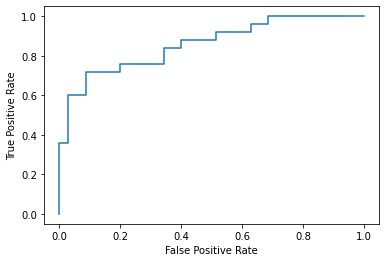

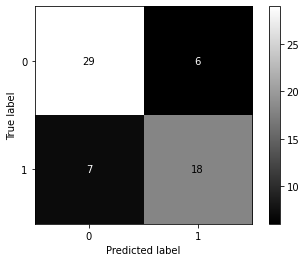

In [401]:
cm = confusion_matrix(ytest, y_predicted)
fpr, tpr, roc_auc = roc_curve(ytest, f_wielomian(my_ridge, xtest))

print("Czulosc ridge:", cm[1][1]/(cm[1][1] + cm[1][0]))

print("Swoistosc ridge:", cm[0][0]/(cm[0][0] + cm[0][1]))

print("Accuracy ridge", (cm[1][1] + cm[0][0]) / (cm[1][1] + cm[0][0] + cm[0][1] + cm[1][0]))

RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
ConfusionMatrixDisplay(cm).plot(cmap='gray')

In [402]:
model_ridge = RidgeClassifier(copy_X=True)

start_ridge = time.perf_counter()
for i in range(repeats):
    model_ridge.fit(xtrain, ytrain)
ridge_time_1 = time.perf_counter() - start_ridge

predict = model_ridge.predict(xtest)

Czulosc ridge: 0.72
Swoistosc ridge: 0.8285714285714286
Accuracy ridge 0.7833333333333333


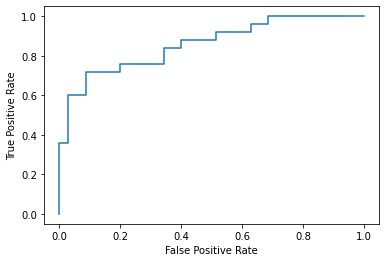

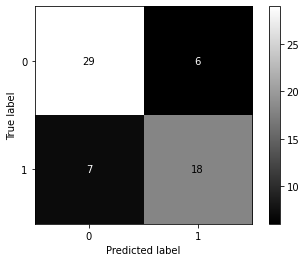

In [403]:
cm = confusion_matrix(ytest, predict)
fpr, tpr, roc_auc = roc_curve(ytest, model_ridge.decision_function(xtest))

print("Czulosc ridge:", cm[1][1]/(cm[1][1] + cm[1][0]))

print("Swoistosc ridge:", cm[0][0]/(cm[0][0] + cm[0][1]))

print("Accuracy ridge", (cm[1][1] + cm[0][0]) / (cm[1][1] + cm[0][0] + cm[0][1] + cm[1][0]))


RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
ConfusionMatrixDisplay(cm).plot(cmap='gray')

In [404]:
x = cleveland[['thal', 'ca', 'oldpeak', 'thalach']]
y = cleveland['class']

xtrain, xtest, ytrain, ytest = train_test_split(x, y, test_size=0.2, train_size=0.8, random_state=seed)

xtest = my_normalize(xtest)
xtrain = my_normalize(xtrain)

C:\Users\Jakub\anaconda3\envs\PUM\lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  return reduction(axis=axis, out=out, **passkwargs)
C:\Users\Jakub\anaconda3\envs\PUM\lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)


In [405]:
start_analytical_2 = time.perf_counter()
for i in range(repeats):
    my_ridge = normal_equation_ridge_regression(xtrain, ytrain, 1)
analytical_time_2 = time.perf_counter() - start_analytical

y_predicted = f_wielomian(my_ridge, xtest)

y_predicted = label_data(y_predicted, 0)

Czulosc ridge: 0.72
Swoistosc ridge: 0.8285714285714286
Accuracy ridge 0.7833333333333333


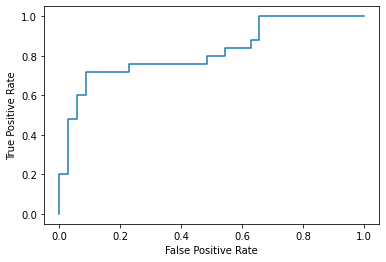

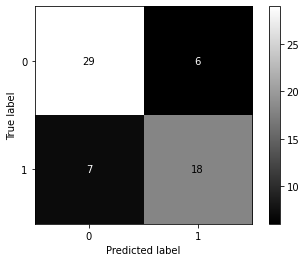

In [406]:
cm = confusion_matrix(ytest, y_predicted)
fpr, tpr, roc_auc = roc_curve(ytest, f_wielomian(my_ridge, xtest))

print("Czulosc ridge:", cm[1][1]/(cm[1][1] + cm[1][0]))

print("Swoistosc ridge:", cm[0][0]/(cm[0][0] + cm[0][1]))

print("Accuracy ridge", (cm[1][1] + cm[0][0]) / (cm[1][1] + cm[0][0] + cm[0][1] + cm[1][0]))

RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
ConfusionMatrixDisplay(cm).plot(cmap='gray')

In [407]:
model_ridge = RidgeClassifier(copy_X=True)

start_ridge_2 = time.perf_counter()
for i in range(repeats):
    model_ridge.fit(xtrain, ytrain)
ridge_time_2 = time.perf_counter() - start_ridge

predict = model_ridge.predict(xtest)

Czulosc ridge: 0.72
Swoistosc ridge: 0.8285714285714286
Accuracy ridge 0.7833333333333333


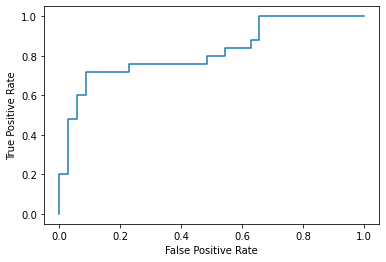

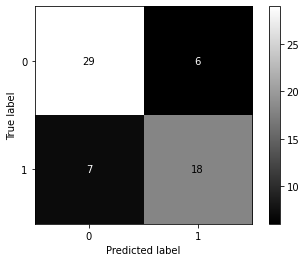

In [408]:
cm = confusion_matrix(ytest, predict)
fpr, tpr, roc_auc = roc_curve(ytest, model_ridge.decision_function(xtest))

print("Czulosc ridge:", cm[1][1]/(cm[1][1] + cm[1][0]))

print("Swoistosc ridge:", cm[0][0]/(cm[0][0] + cm[0][1]))

print("Accuracy ridge", (cm[1][1] + cm[0][0]) / (cm[1][1] + cm[0][0] + cm[0][1] + cm[1][0]))

RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
ConfusionMatrixDisplay(cm).plot(cmap='gray')

In [409]:
x = cleveland.drop(columns='class')
y = cleveland['class']

model_ridge = RidgeClassifier(copy_X=True)

sfs_selector = sfs(model_ridge, n_features_to_select=4)
sfs_selector.fit(x, y)
sfs_selector.get_feature_names_out()

new_x = cleveland[sfs_selector.get_feature_names_out()]

xtrain, xtest, ytrain, ytest = train_test_split(new_x, y, test_size=0.2, train_size=0.8, random_state=seed)

xtest = my_normalize(xtest)
xtrain = my_normalize(xtrain)

C:\Users\Jakub\anaconda3\envs\PUM\lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: In a future version, DataFrame.min(axis=None) will return a scalar min over the entire DataFrame. To retain the old behavior, use 'frame.min(axis=0)' or just 'frame.min()'
  return reduction(axis=axis, out=out, **passkwargs)
C:\Users\Jakub\anaconda3\envs\PUM\lib\site-packages\numpy\core\fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)


In [410]:
start_analytical_3 = time.perf_counter()
for i in range(repeats):
    my_ridge = normal_equation_ridge_regression(xtrain, ytrain, 1)
analytical_time_3 = time.perf_counter() - start_analytical

y_predicted = f_wielomian(my_ridge, xtest)

y_predicted = label_data(y_predicted, 0)

Czulosc ridge: 0.72
Swoistosc ridge: 0.8571428571428571
Accuracy ridge 0.8


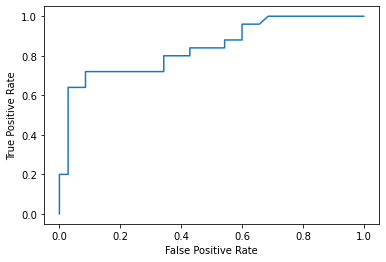

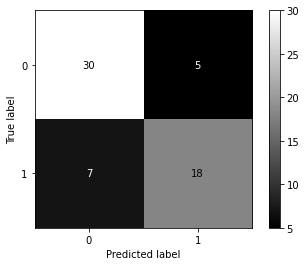

In [411]:
cm = confusion_matrix(ytest, y_predicted)
fpr, tpr, roc_auc = roc_curve(ytest, f_wielomian(my_ridge, xtest))

print("Czulosc ridge:", cm[1][1]/(cm[1][1] + cm[1][0]))

print("Swoistosc ridge:", cm[0][0]/(cm[0][0] + cm[0][1]))

print("Accuracy ridge", (cm[1][1] + cm[0][0]) / (cm[1][1] + cm[0][0] + cm[0][1] + cm[1][0]))

RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
ConfusionMatrixDisplay(cm).plot(cmap='gray')

In [412]:
model_ridge = RidgeClassifier(copy_X=True)

start_ridge_3 = time.perf_counter()
for i in range(repeats):
    model_ridge.fit(xtrain, ytrain)
ridge_time_3 = time.perf_counter() - start_ridge

predict = model_ridge.predict(xtest)

Czulosc ridge: 0.72
Swoistosc ridge: 0.8571428571428571
Accuracy ridge 0.8


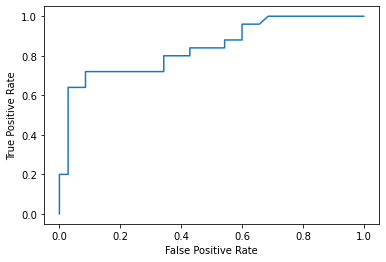

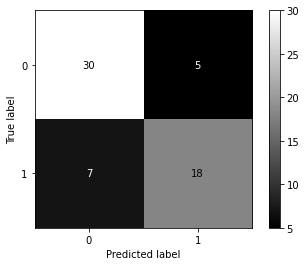

In [413]:
cm = confusion_matrix(ytest, predict)
fpr, tpr, roc_auc = roc_curve(ytest, model_ridge.decision_function(xtest))

print("Czulosc ridge:", cm[1][1]/(cm[1][1] + cm[1][0]))

print("Swoistosc ridge:", cm[0][0]/(cm[0][0] + cm[0][1]))

print("Accuracy ridge", (cm[1][1] + cm[0][0]) / (cm[1][1] + cm[0][0] + cm[0][1] + cm[1][0]))

RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
ConfusionMatrixDisplay(cm).plot(cmap='gray')

In [414]:
print("Czas wykonania analitycznego: ", analytical_time_1)
print("Czas wykonania analitycznego: ", analytical_time_2)
print("Czas wykonania analitycznego: ", analytical_time_3)

print("Czas wykonania ridge: ", ridge_time_1)
print("Czas wykonania ridge: ", ridge_time_2)
print("Czas wykonania ridge: ", ridge_time_3)

Czas wykonania analitycznego:  3.4253179999941494
Czas wykonania analitycznego:  4.1953568999888375
Czas wykonania analitycznego:  5.458916799980216
Czas wykonania ridge:  0.18032879999373108
Czas wykonania ridge:  0.9470382999861613
Czas wykonania ridge:  2.204227699985495


### Wnioski

Implementacja analityczna i ta z sklearn daly takie same wyniki

Przy wyborze najbardziej skorelowanych cech wyniki sie poprawily

Przy automatycznym wyborze cech wyniki poprawily sie jeszcze bardziej